# Machine Learning in Python - Project 2

Due Friday, April 15th by 5 pm UK local time.
---
- Annette Bell (s2089966)
- Billie Harris (s2264941)
- James Grant (s2087525)
- Adrián Garnier Artiñano (s2246745)

## 0. Setup

In [ ]:
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd

pd.options.mode.chained_assignment = None
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(palette=sns.dark_palette("#69d", reverse=True, n_colors=3))

# sklearn modules
import sklearn
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.base import clone

# Tree Visualization
from six import StringIO
from IPython.display import Image
import pydotplus
from typing import List

In [ ]:
from google.colab import drive
import os

drive.mount("/content/drive")
# os.chdir("drive/My Drive/Colab Notebooks/mlp/project-2")
os.chdir("/content/drive/.shortcut-targets-by-id/1_TaRiM0irjrnNHm8X2ACY5UNrpxhmavR/project-2")  # Annette

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data
d = pd.read_csv("hotel.csv")
# Retaining the original data.
original_d = d.copy()

## 1. Introduction

In order to maximise profits and provide the best possible customer service, it is vital for hotel operators to understand when and why customers will cancel their reservations. Using booking data from one operator's Resort and City Hotels between July 2015 and August 2017, we seek to determine which features are most determinative of booking cancelations occuring or not by using this data as input within machine learning algorithms. We specifically use the feature `is_canceled` from the [Antonio, Almeida and Nunes, 2019] dataset on hotel bookings, as our outcome of interest.

To ensure that our findings will be useful to the hotel operator such that it can make effective, and impactful, decisions related to cancelations in the future, we aim to build a highly accurate model with specific emphasis on having high recall (i.e. low rates of false positives and false negatives). In this context, a *false negative* occurs if the model predicts that a guest will not cancel their booking when, in fact, they do, whereas a *false positive* occurs when the model predicts that a guest will cancel their booking but they do not. As both of these outcomes have significant negative repercussions on the hotel operators profit, customer relations, and operations, our model must minimise them.

In doing so we have found that how far in advance a customer makes a booking (**`lead_time`**), and the type of deposit they select for their booking (**`deposit_type`**) are two major features that have significant imapact on whether a booking will be canceled or not. We shall discuss these features, along with others, further in Section 4 of our report.

 <br>

--- 

To better understand how we arrived at our final recommendations, we will first, outline our exploratory data analysis and feature engineering. We will then discuss our model creation and tuning process before, finally, discussing the results of the model and clearly stating our findings and recommendations to the hotel operator.

<br>

## 2. Exploratory Data Analysis and Feature Engineering
Our aim is to determine certain factors that affect the likelihood of a booking, for either of the Resort or City Hotels, being canceled. Before we build a model to do this, however, it is important to examine the dataset for any easily identifiable patterns between features. 

Additionally, due to this being a raw dataset, there are a number of anomalies and irregularities that must be addressed. We explore these before concluding whether to keep them within the dataset or not, depending on the effect that they could potentially have on the performance of the model. 

---

### Data Exploration and Cleaning 

In order for us to create a model with a high degree of accuracy, we shall begin by briefly examining the original dataset we received as well as the data types which state if a column is an object (ex. "Resort Hotel"), float (ex. 2.0), or integer (ex. 40). This will allow us to examine objects first as they are not compatable with a numeric machine learning algorithms.

**Please note:** *in this section, we state which changes we will make and why; however, we do not implement them until the end of this section through the use of a function.*

**Changing Data Types**

In [ ]:
# Exploring the datatypes of the features of a booking within the dataset.
original_d.dtypes.value_counts()

int64      16
object     10
float64     4
dtype: int64

By examining some values in the dataset as well as the datatypes of each of the features, we see that 10 of the 30 features in the dataset are objects. Additionally, we notice that some of the float datatypes should be converted to integers.  

As machine learning algorithms require numeric data to generate a solution, we must examine the object type features to determine the best method to make these features compatible with the model (i.e. the best way to transfom these features into numeric data types).

Below we explore feautures in our dataset that are currently objects.

In [ ]:
# Displaying the categories for each of the object features within the dataset.
for i in list(original_d.dtypes[original_d.dtypes == "object"].index):
  if len(set(original_d[i])) < 20:
    print(f"\033[1m{i}\033[0m ({len(set(original_d[i]))}): {set(original_d[i])}",sep="")
  else:
    print('\033[1m', i,'\033[0m', " (", len(set(original_d[i])),"): ", list(set(original_d[i]))[:10], "...", sep="")

hotel (2): {'Resort Hotel', 'City Hotel'}
arrival_date_month (12): {'May', 'April', 'December', 'February', 'September', 'July', 'January', 'June', 'March', 'November', 'October', 'August'}
meal (5): {'FB', 'HB', 'Undefined', 'SC', 'BB'}
country (178): [nan, 'KHM', 'IMN', 'STP', 'CAF', 'URY', 'AZE', 'NCL', 'SGP', 'GUY']...
market_segment (8): {'Groups', 'Online TA', 'Offline TA/TO', 'Complementary', 'Undefined', 'Aviation', 'Direct', 'Corporate'}
distribution_channel (5): {'TA/TO', 'GDS', 'Undefined', 'Direct', 'Corporate'}
reserved_room_type (10): {'G', 'D', 'C', 'F', 'P', 'A', 'E', 'L', 'H', 'B'}
assigned_room_type (12): {'H', 'K', 'G', 'D', 'C', 'F', 'P', 'A', 'E', 'L', 'B', 'I'}
deposit_type (3): {'Non Refund', 'No Deposit', 'Refundable'}
customer_type (4): {'Transient', 'Transient-Party', 'Contract', 'Group'}


From the above, we realise that ```hotel``` is currently a binary object indicating whether a hotel is a "Resort Hotel" or "City Hotel." For this reason, **we will change the name of the ```hotel``` feature to ```is_resort```, where the value 1 will indicate a booking for the "Resort Hotel" and 0 will indicate a booking for the "City Hotel"**.

Additionally, we notice that ```arrival_date_month``` are the months of the year. To include this feature in the model, we will need to convert it to numeric. **We will make each month correspond to a number beginning with January as 1 and ending with December as 12**. 

For the features **(```meal```, ```market_segment```, ```distribution_channel```, ```reserved_room_type```, ```assigned_room_type```, ```deposit_type```, and ```customer_type```)**, we observe that each has a very low number of unique attributes. As such, **we will perform one hot encoding utilizing a helper function called ```one_hot_encoding```** as doing so will not unreasonably increase the datasets dimensionality.

It is likely that we will also perform one hot encoding on ```country```. However, we appreciate that, unlike most of the "object features" within the  dataset, ```country``` has a significant amount of unique attributes. As such, performing one hot encoding on this feature would significantly increase the dataset's dimensionality and cause vast computational expense when inputted into a machine learning algorithm. Hence, we further investigate this feature to determine if there are other methods to convert it to a numerical datatype while limiting dimensionality.

From the reprinted code above, we notice that there are bookings from 178 different countries. But, there are also a number of bookings that are missing the information regarding the guest's country of origin. This could have an affect on the performance of our model in how well it is able to predict cancelations. Therefore, we next address missing information within the dataset.

<br>

---

**Missing Data**

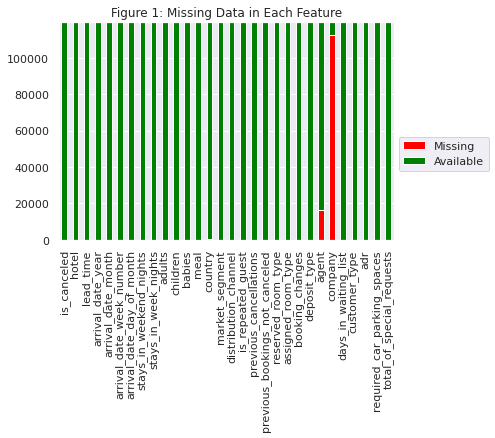

Missing amount per column: 
children         4
country        488
agent        16340
company     112593
dtype: int64


In [ ]:
# Create a dataframe regarding missing entries within the dataset.
null_df = original_d.isnull()
missing_list = null_df.sum(axis=0)
missing_df = missing_list.to_frame(name="Missing")
missing_df["Available"] = len(original_d.index) - missing_df["Missing"]

# Plots the number of missing entries per feature of a booking.
missing_df.plot(kind="bar", stacked=True, color=["red", "green"], figsize=(6, 4))
plt.title("Figure 1: Missing Data in Each Feature")
plt.legend(loc="best", bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)
plt.ylim(0, len(original_d.index))
plt.show()
print("Missing amount per column: ")
print(original_d[["children","country","agent","company"]].isna().sum())

In Figure 1, we see that there are four columns that have missing data: ```children```, ```country```, ```agent```, and ```company```. Since there are less than 500 total observations (of the 119,390) that have missing data on ```children``` and ```country```, we simply drop these reservations from the dataset. **More specifically, we will remove the reservations where ```children``` and/or ```country``` contain NaN**.

Conversly, we observe that the number of observations missing information for the features ```agent``` and ```company``` is considerably high with 16,340 and 112,593 total missing observations, respectively. As such, we shall examine these features in more detail as simply dropping these observations would leave us with an overly sparse dataset. Moreover, we are hesitant to drop ```agent``` or ```country``` as features from the dataset as it is possible that one, or both, of these features could have high predictive power.

<br>

---

To better understand the distribution of reservations with regards to ```country```, we visually inspect this feature.


In [ ]:
#view distribution of country (only keeping key elements)
print("\033[1mTable 1: Overview  of Country Distribution\033[0m")
original_d.country.value_counts().describe()[["count", "mean", "std","75%", "max"]].to_frame()

Table 1: Overview  of Country Distribution


,country
count,177.000000
mean,671.762712
std,3931.154035
75%,74.000000
max,48590.000000


From the table above, we find that 75% of the 177 countries have 74 or less total reservations. Reservations from such countries make up a small percentage of the total number and hence it seems logical to group these reservations together in some way. 

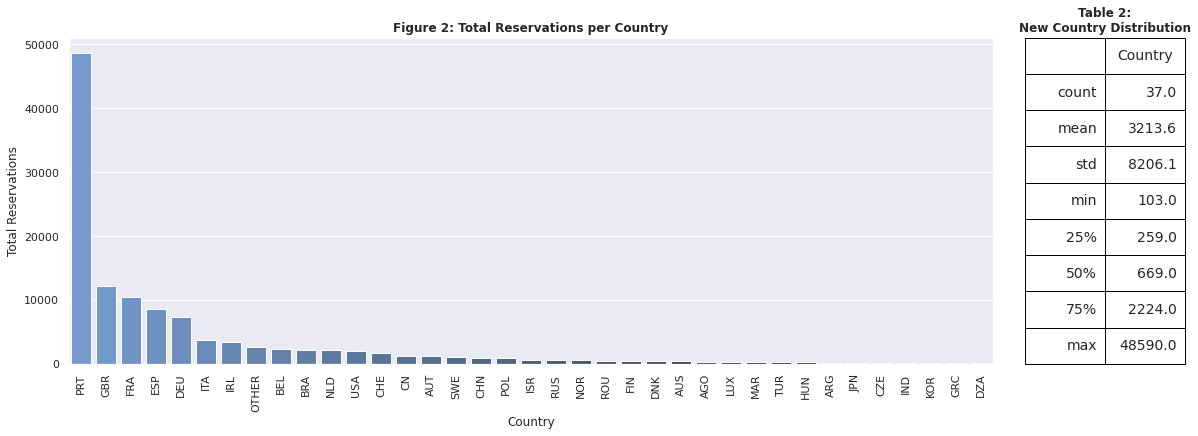

In [ ]:
#create dataframe with 80th percentile grouping
count_dt = original_d["country"].value_counts()
country_grouped = pd.DataFrame(count_dt[count_dt > count_dt.quantile(0.8)])
country_grouped.loc["OTHER"] = sum(count_dt[count_dt <= count_dt.quantile(0.8)])
country_grouped = country_grouped.sort_values(by=["country"], ascending=False)

#plot histogram
fig = plt.figure(figsize=(20, 6))
ax0 = plt.subplot2grid((1, 6), (0, 0), colspan=5)
sns.barplot(x=country_grouped.index, y=country_grouped["country"],
            palette=sns.dark_palette("#69d", reverse=True, n_colors=len(country_grouped.index)))
plt.xticks(rotation=90)
plt.ylabel("Total Reservations")
plt.xlabel("Country")
plt.title("Figure 2: Total Reservations per Country", fontweight="bold")

#create distribution table
ax1 = plt.subplot2grid((1, 6), (0, 5))
font_size = 14
bbox = [0, 0, 1, 1]
ax1.axis("off")
table_vals = np.column_stack((country_grouped.describe().index,
                              [round(x, 1) for x in country_grouped.country.describe()]))
mpl_table = ax1.table(cellText=table_vals, bbox=bbox, colLabels=["", "Country"])
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)
plt.title("Table 2:\nNew Country Distribution", fontweight="bold")
plt.show()

In Figure 2, we see the affects of grouping together the reservations from countries that are below the 80% quantile and creating a new attribute "Other" that encompasses all of these other countries with small  numbers of bookings. In doing so, "Other" becomes the eighth largest "country" for reservations. This isn't majorly concerning as (1) the distribution of ```country``` is similar to what it was previously and (2) we believe that we have not pulled too many data points as to decrease the predictability of the model. Additionally, we believe that the data in this format is actually of more use to the hotel operator than before. By grouping countries in this way, the hotel operator may be able to prevent cancelations from all of these countries using the same strategy, saving time and resources. For these reasons, we believe the 80% quantile is an acceptable split point, and as such, **in addition to removing the NAs, we will also rename all countries within the 80% quantile and smaller to a country entitled "Other_Country". Finally, we will one hot encode the updated column**.

<br>

---
Now we will examine the features ```agent``` and ```company```, as these two features are also missing large amounts of reservation details.

As a reminder, ```company``` is defined as the "ID of the company/entity that made the booking or responsible for paying the booking" and ```agent``` is defined as the "ID of the travel agency that made the booking". Based on this understanding of the two columns, we assmue that an NA value for ```company``` indicates that a company did not make the reservation. Similarly, we assume that NAs for ```agent```  implies that the indivdual or group did not book through a travel agency. Therefore, it does not make sense to remove these bookings because according to these assumptions, we are still able to ascertain their company or agent status, which may be useful when predicting cancelations. **For this reason, we will fill all NA values for ```company``` and ```agent``` with 0s**, as this value is not already assigned to a company nor an agent.

By converting NAs to 0s, we can now quickly examine how the distribution of both of these features have changed. 

In [ ]:
#view distribution of company and agent when NAs=0
print("\033[1mTable 3: Distribution of Company and Agent when NAs=0\033[0m")
pd.DataFrame(zip([round(x, 1) for x in original_d.company.fillna(0).describe()],
                 [round(x, 1) for x in original_d.agent.fillna(0).describe()],),
             index=original_d.describe().index, columns=["company", "agent"])

Table 3: Distribution of Company and Agent when NAs=0


,company,agent
count,119390.0,119390.0
mean,10.8,74.8
std,53.9,107.1
min,0.0,0.0
25%,0.0,7.0
50%,0.0,9.0
75%,0.0,152.0
max,543.0,535.0


From Table 3, we can see the distribution of `company` and `agent` when we convert the NAs in these columns to 0s. From the missing data plot shown earlier in the code (Figure 1), we know that 112,593 (~95%) of the data points were missing for `company`. Based on our improved understanding of what NA means with regard to this feature, we now know that this means that nearly 95% of the reservations were not made through a company. For this reason, **we will create a new binary feature called "is_with_company" which takes a value of 0 if the reservation was made without a company and 1 otherwise. We will then delete `company`**. 

With regards to ```agent```, we know that 16,340 (~13%) reservations were booked without an agent. From the distribution, it appears that we cannot simply make this feature a binary. For this reason, we will take a closer look at the distributions of reservations given a specific agent.  

In [ ]:
#create agent dataframe where NAs are 0s
agent0 = original_d["agent"].fillna(0).value_counts()

#view distribution of country (only keeping key elements)
print("\033[1mTable 4: Overview  of Agent Distribution when NAs=0\033[0m")
agent0.reset_index().agent.describe()[["count", "mean", "std", "75%", "max"]].to_frame()

Table 4: Overview  of Agent Distribution when NAs=0


,agent
count,334.000000
mean,357.455090
std,2164.112713
75%,103.000000
max,31961.000000


We can see that Table 4's distribution is similar to `country`'s results in that there is an extremely large standard deviation and max count with a small 75% quantile. For this reason, we conduct similar analysis to examine the affects of grouping agents with counts less than the 80th percentile together.

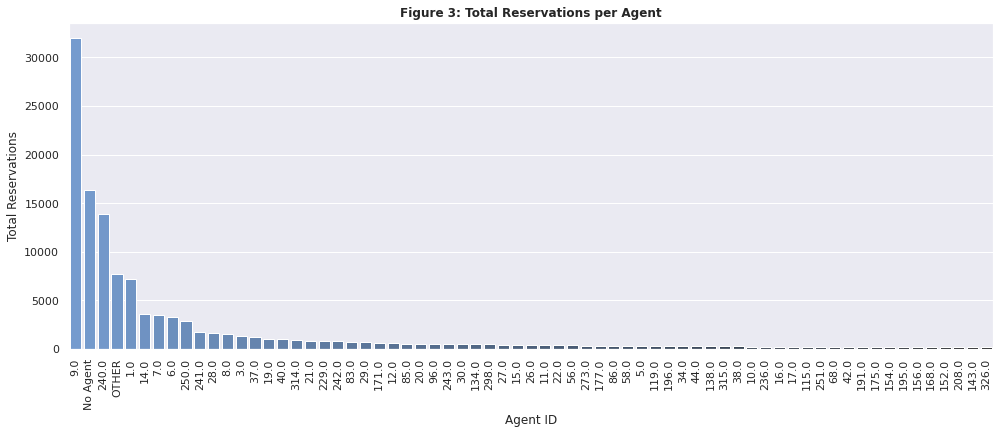

In [ ]:
# pull agent data
agent_grouped = pd.DataFrame(agent0[agent0 > agent0.quantile(0.8)])
agent_grouped.loc["OTHER"] = sum(agent0[agent0 <= agent0.quantile(0.8)])
agent_grouped = agent_grouped.sort_values(by=["agent"], ascending=False)
agent_grouped = agent_grouped.rename(index={0.0: "No Agent"})

# plot histogram of agent when grouped and NA=0
fig = plt.figure(figsize=(20, 6))
ax0 = plt.subplot2grid((1, 6), (0, 0), colspan=5)
sns.barplot(x=agent_grouped.index, y=agent_grouped["agent"],
            palette=sns.dark_palette("#69d", reverse=True, n_colors=len(agent_grouped.index)))
plt.xticks(rotation=90)
plt.ylabel("Total Reservations")
plt.xlabel("Agent ID")
plt.title("Figure 3: Total Reservations per Agent", fontweight="bold")
plt.show()

From Figure 3, we notice similar trends as to when we altered the `country` feature. By this we mean that once again, after introducing the "Other" category, the distribution retains a similar shape and the count for this new category is not too disimilar to counts observed for other categories within this feature. As such **we will use the helper-function `create_other_category_under_percentile` to rename all agents with counts below the 80% quantile to "Other_Agent", and subsequently use one hot encoding on the feature `agent`.** By labeling this as `Other_Agent` to ensure continued clarity within our dataset.  

We note here that in the original dataset, both `country` and `agent` are categorical pieces of data each with a high number of attributes (or categories). These features are therefore highly descriptive and may help to explain why some hotel bookings are canceled. Therefore, we decided not to remove them from the dataset. However, because of how descriptive these features are, we conclude it is not feasible to retain each of these categories and perfrom one hot encoding creating a new feature for each one of the categories. If we did so, our dataset would become too large to perform analysis on. Furthermore, we recognize that an agent or country with less than 100 bookings (of the 119,390 reservations) will always be statistically insignificant as it accounts for 0.083759108% of the data. This is why we have adapted these two features as described above; we have retained the most useful categories (those with the highest counts) while combining all other bookings that do not make up a significant proportion of the hotel operator's business. 


Now, that all of the categorical features are examined, we begin to look at the features that are currently floats. 

<br>

---

**Float Data Types**:

A preview of some entires for the features that are currently floats within our dataset can be found in Table 5. 

In [ ]:
print("Floats in dataframe: "+ str(list(original_d.dtypes[original_d.dtypes == "float64"].index)))

Floats in dataframe: ['children', 'agent', 'company', 'adr']


As a reminder, we have closely examined and determined how to modify both `agent` and `company` to meet the necessary requirements to run a model requiring numeric datatypes. The remaining features we must analyse are `adr` and `children`. 

The feature ```adr``` is "the Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights". Looking at this definition, we see that it is logical for this feature to remain as a float, because rounding these numbers to integers may decrease this feature's predictive power (and hence reduce the accuracy of our model). However, as we cannot have half an individual, we shall round the feature `children` to increase the usefulness of our results. 

To determine if further modification of these features is necessary, we examine their distributions more closely. It is important to note, that although not a float, the dataset also has a feature entitled `babies` As this category is similar to children, we will include it in the table.

In [ ]:
#Examine key aspects of distribution of adr children, and babies
print("\033[1mTable 5: Distribution of adr, children, and babies\033[0m")
original_d[["adr", "children", "babies"]].describe().iloc[[0,1,2,3,6,7]]#.to_frame()

Table 5: Distribution of adr, children, and babies


,adr,children,babies
count,119390.000000,119386.000000,119390.000000
mean,101.831122,0.103890,0.007949
std,50.535790,0.398561,0.097436
min,-6.380000,0.000000,0.000000
75%,126.000000,0.000000,0.000000
max,5400.000000,10.000000,10.000000


Inspecting Table 5 above, we notice that there is at least one negative value for the average daily rate (```adr```). While abnormal, we believe that there are a number of plausible explanations for this. For example, a guest could have been refunded or been given a gift card for another stay at the hotel. As we do not notice any other major issues, we select to keep ```adr``` in its original form. 

However, when we examine ```children``` and ```babies```, we see that the majority of the values for both features are 0. As such a small number of boookings include a dependent (a child or a baby), we decide that a binary indicator may be a better way to represent this feature. 

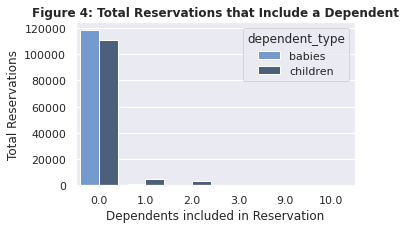

In [ ]:
#pull dependent data
dependent_df = pd.DataFrame(pd.melt(original_d[["children", "babies"]]).value_counts())
dependent_df = dependent_df.reset_index()
dependent_df.columns = ["dependent_type", "number", "count"]

#plot counts of babies/children on reservations
fig = plt.figure(figsize=(5, 3))
sns.barplot(x="number", y="count", hue="dependent_type", data=dependent_df)
plt.ylabel("Total Reservations")
plt.xlabel("Dependents included in Reservation")
plt.title("Figure 4: Total Reservations that Include a Dependent", fontweight="bold")
plt.show()

From Figure 4, we see that for the majority of reservations, neither children nor babies are included in a reservation. For this reason, **we will make both ```children``` and ```babies``` bianry columns where 1 means that at least one child or baby is included in the reservation and 0 otherwise**. 

<br>

----

Now that we have reviewed the majority of the features and modified them accordingly, we consider the following aspects of hotel bookings:
1. Are there any "duplicate" reservations? 
2. Are there any reservations that do not have a individual/group staying overnight?
3. Are there reservations without people?

In [ ]:
# Amount of duplicate rows
print("Duplicated rows: ", sum(original_d.duplicated()), "\n")

# Display entries without reserved nights
filter = (original_d.stays_in_weekend_nights == 0) & (original_d.stays_in_week_nights == 0)
print(f"Reservations with 0 nights: {len(original_d[filter])}", "\n")

# Display entries without reserved people
filter = ((original_d.children == 0) & (original_d.adults == 0) & (original_d.babies == 0))
print(f"Reservations without people (no adults, children, nor babies): {len(original_d[filter])}")

Duplicated rows:  32252 

Reservations with 0 nights: 715 

Reservations without people (no adults, children, nor babies): 180


From this information, we notice there are over 32,000 reservations that are duplicated. We appreciate that some of these may be because of errors in the system. However, they could also be due to individuals or companies making mutiple similar bookings. For example, for comapny conferences or weddings, one billpayer may front the costs and book for the whole party under one name. As there is no way for us to determine if these duplicates are errors or not, we shall assume that all duplicate bookings are group bookings and therefore retain these within our model. If we were to remove these, we could be losing valuable information that could affect the way the hotel operator prevents cancelations in the future.

There are a number of bookings for which the number of nights stayed midweek and on the weekend are both 0. We acknowledge that it is possibe for a booking to be made with no nights stay if the room is booked for the purpose of getting ready for a daytime event such as a conference or a wedding. However, we assume that if a room is being booked, the guests are travelling and so it would not be unreasonable to assume that they would need a place to stay (either the night before or the evening after) to minimise the amount of travel needed in a given day. Additionally, for cleaning purposes, many hotels have a policy that rooms must be booked for at least one night. Furthermore, as this is a raw dataset, we assume that this is due to an error in the system, and hence **we shall drop bookings without an overnight stay from the dataset**. 

Similarly, there are a number of bookings for which the number of guests is set to zero. In order for the hotel to prepare the correct number of beds, it is common that the number of guests is required by the hotel when requesting a room. Therefore, we take such entires to be errors within the data and once again **remove bookings without individuals (i.e. adults=0 AND children=0 AND babies=0) from our dataframe**. 



<br>

---
**Removing Features:**

Our final step is to determine if all of the features in the dataset are useful to the hotel operator in helping them predict and prevent canceled bookings.

The first feature we consider here is ```arrival_date_year``` which details the year in which the guest arrived for their stay at one of the two hotels. 


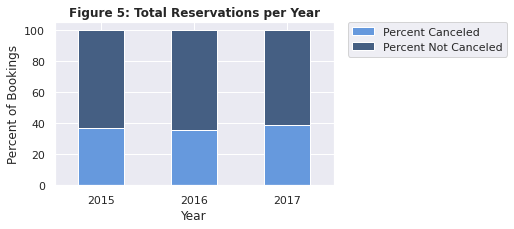

In [ ]:
canceled_per_year = []
# Iterates through all of the years in the data and calculates the percetage of
# bookings for that year that are then canceled.
for i in sorted(original_d["arrival_date_year"].unique()):
    percent_of_canceled = ((original_d["is_canceled"].where(original_d["arrival_date_year"] == i)).sum() / 
                           (original_d["is_canceled"].where(original_d["arrival_date_year"] == i)).count()* 100)
    canceled_per_year.append(percent_of_canceled)

#create cancelation df
year_df = pd.DataFrame(index=sorted(original_d["arrival_date_year"].unique()),
                       columns=["Percent Canceled", "Percent Not Canceled"])
year_df["Percent Canceled"] = canceled_per_year
year_df["Percent Not Canceled"] = 100 - year_df["Percent Canceled"]

#plot
year_df.plot(kind="bar", stacked=True, figsize=(5, 3))
plt.ylabel("Percent of Bookings")
plt.xlabel("Year")
plt.xticks(rotation=0)
plt.title("Figure 5: Total Reservations per Year", fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc="best", borderaxespad=0)

Figure 5 depicts the percentage of reservations for each year that are canceled vs. not canceled. This indicates that the percentage of canceled bookings is relatively stable over the three years, suggesting that `arrival_date_year` will not have much predictive power in the model as it does not provide a strong indication as to whether a booking will be canceled or not. Additionally, we appreciate that we only have data from 3 years, as this is a small number it is difficult to ascertain any patterns with regard to how year will affect cancelations. Finally, we note that the hotel operators cannot retroactively prevent a cancelation. Because of this, we have chosen to **remove `arrival_date_year` from our dataset**. 

Next, we noticed that there were three features that indicated at what period of the year a booking was made for: ```arrival_date_month```, ```arrival_date_week_number```,  and ```arrival_date_day_of_month```. We deemed it unecessary to have all three of these features within our model and instead decided that we needed only ```arrival_date_week_number``` or ```arrival_date_month``` and ```arrival_date_day_of_month``` together. Due to the way that dates work, it is much more common for businesses and people to plan using the day of the month and the month of the year. For example, people may decide to go on holdiay after a pay day (which is typically at the end of the month) or during school holidays (with the longer holiday taking place in the summer months). This idea is confirmed by Figure 8 below, as we see that the total number of reservations and hence the number of cancelations fluctuate at various months of the year. 

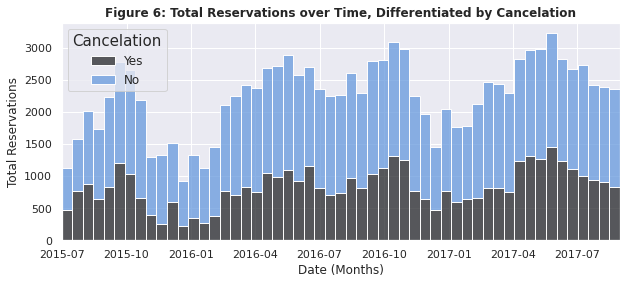

In [ ]:
#create dataframe of is_canceled and datetime
date_df = original_d[["is_canceled", "arrival_date_day_of_month", "arrival_date_year"]]
months = {"January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6, "July": 7,
          "August": 8, "September": 9, "October": 10, "November": 11, "December": 12}
date_df["arrival_date_month"] = original_d.arrival_date_month.map(months)
date_df = date_df.dropna(subset=["arrival_date_month"])
date_df.columns = ["is_canceled", "day", "year", "month"]
date_df["date"] = pd.to_datetime(date_df[["year", "month", "day"]])

#plot reservations by month
fig = plt.figure(figsize=(10, 4))
sns.histplot(data=date_df, x="date", hue="is_canceled", multiple="stack", 
             palette=sns.dark_palette("#69d", reverse=True, n_colors=2))
plt.ylabel("Total Reservations")
plt.xlabel("Date (Months)")
plt.xlim(date_df["date"].min(), date_df["date"].max())
plt.title("Figure 6: Total Reservations over Time, Differentiated by Cancelation", fontweight="bold")
plt.legend(["Yes", "No"], loc="upper left", title="Cancelation", fontsize=12, title_fontsize=15)

Hence, we decided that while using only ```arrival_date_week_number``` would reduce the dimensionality of our dataset further, it would be less useful in helping the staff at the hotel operator in predicting cancelations. Accordingly, we **remove ```arrival_date_week_number``` from our dataset**.

<br>

---

Now that we have decided how to modify the given data to create a model with a high degree of accuracy, we utilize the function ```modify_data``` to implement the changes we have discussed in this section so far. 

In [ ]:
def create_other_category_under_percentile(
    series: pd.Series, other: str, quantile: float = 0.8
) -> pd.Series:
    """
    Retains the categories that are most important and combines
    the rest that are under a certain threshold into one grouping.
    Inputs:
      series: Array containing feature to modify
      other: name of the new grouping
      quantile: size of the quantile to group
    Outputs:
      out_series: Array containing major categories and new combined category
    """
    x = series
    value_series = x.value_counts()
    key_dict = value_series.to_dict()
    percentile = value_series.quantile(quantile)
    nparray = np.empty(value_series.shape[0])
    for index, item in enumerate(value_series.index):
        nparray[index] = key_dict[item]
    out_series = pd.Series(
        np.where(nparray >= percentile, value_series.values, other), value_series.index)
    return out_series


def one_hot_encoding(df: pd.DataFrame, column_names: List[str]) -> pd.DataFrame:
    """
    One hot encoded categorical data within a dataframe
    Inputs:
      df: DataFrame with categorical data features
      column_names: List of columns that you wish to perform OHE on. This list
      *MUST* be all categorical data
    Outputs:
      results_df: DataFrame with newly added OHE features as well as all other
      features not included in the list
    """
    dummies = pd.get_dummies(df[column_names])
    results_df = df.drop(df[column_names], axis=1)
    results_df = pd.concat([results_df, dummies], axis="columns")
    return results_df


def modify_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Make all changes to desired df, d, specified during section 2
    Inputs:
      df: dataframe we will modify
    Outputs:
      df: modified dataframe
    """

    # Remove reservations without people
    filter1 = (df.children == 0) & (df.adults == 0) & (df.babies == 0)
    df = df[~filter1]

    # Remove reservations without reserved days
    filter2 = (df.stays_in_weekend_nights == 0) & (df.stays_in_week_nights == 0)
    df = df[~filter2]

    # convert categorical months into numeric
    months = {"January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6, "July": 7,
              "August": 8, "September": 9, "October": 10, "November": 11, "December": 12}
    df["arrival_date_month"] = df.arrival_date_month.map(months)

    # Drop the 4 nan in children, convert to int64, and make binary.
    df = df.dropna(subset=["children"])
    df.children = df.children.astype("int64")
    df.children = pd.Series(np.where(d.children.values > 0, 1, 0), d.index)

    # convert babies to binary
    df.babies = pd.Series(np.where(d.babies.values > 0, 1, 0), d.index)

    # Set company to binary is_with_company, set to integer, and drop company
    df["is_with_company"] = (df.company.where(df["company"].isnull(), 1).fillna(0).astype(int))
    df.is_with_company = df.is_with_company.astype("int64")
    df = df.drop(["company"], axis=1)

    # Drop the na in countries.
    df = df.dropna(subset=["country"])

    # Fill the NA company with a 0, that is self bought.
    df.agent = df.agent.fillna(0)

    # Get the largest ones.
    df.country = create_other_category_under_percentile(df.loc[:, "country"], "Other_Country")
    df.agent = create_other_category_under_percentile(df.loc[:, "agent"], "Other_Agent")

    # create new binary of hotel typedata
    df["is_resort"] = df.hotel.map({"Resort Hotel": 1, "City Hotel": 0})
    df = df.drop(["hotel"], axis=1)

    # Encode categories into OHE
    df = one_hot_encoding(df,["customer_type", "meal", "country",  "market_segment", "distribution_channel", 
                              "reserved_room_type", "assigned_room_type", "agent", "deposit_type"])

    # drop specified columns
    df = df.drop(["arrival_date_year", "arrival_date_week_number"], axis=1)

    return df


d = modify_data(d)

<br>

---
### Exploring the Modified Data

We shall now explore this modified dataset to determine some features that could have an effect on cancelations. Doing so will help us to verify our model's results momentarily. 

We begin by inspecting the correlation of some of the features with the variable of interest ```is_canceled```.

In [ ]:
# d_corr code: (Stack Overflow, n.d.)
#create correlation mdataframe in format ["feat1", "feat2", "corr"] without repeats and 1s
d_corr = d.corr().stack().reset_index()
d_corr.columns = ["feat1", "feat2", "corr"]
mask_dups = (d_corr[["feat1", "feat2"]].apply(frozenset, axis=1).duplicated()) | (
    d_corr["feat1"] == d_corr["feat2"])
d_corr = d_corr[~mask_dups]

#display correlations with is_canceled (|<0.25|)
print("There are ", len(d.columns), " features within the processed dataset including variable " + 
      "(of interest: is_canceled).\n", sep="")
print("\033[1mTable 6: Larger Correlations between Features and 'is_Canceled'\033[0m")
corr_cancel = d_corr.loc[(d_corr["feat1"] == "is_canceled") & (abs(d_corr["corr"]) > 0.25)]
corr_cancel.sort_values(by=["corr"]).style.bar(
    subset=["corr"], color=["#d65f5f", "#3BCC53"], vmin=-1, vmax=1, axis=0, align="mid")

There are 124 features within the processed dataset including variable (of interest: is_canceled).

Table 6: Larger Correlations between Features and 'is_Canceled'


,feat1,feat2,corr
121,is_canceled,deposit_type_No Deposit,-0.477341
1,is_canceled,lead_time,0.290242
122,is_canceled,deposit_type_Non Refund,0.480916


From Table 6 above, we see that of the 123 other features, only 3 have relatively high correlations with `is_canceled` (where we label a correlation to be relatively high if the absolute value is greater than 0.25). 

Two of the features that appear to be the most correlated to ```is_canceled``` are ```deposit_type_Non Refund``` and ```deposit_type_No Deposit```. Both of these features are as a result of one-hot encoding of the feature ```deposit_type``` from our original dataset, which we explore below. 


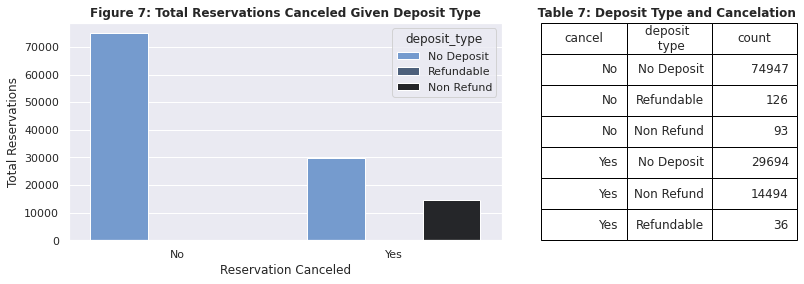

In [ ]:
#pull all deposit data
deposit_df = original_d[["is_canceled", "deposit_type"]].value_counts()
deposit_df = deposit_df.reset_index()
deposit_df = deposit_df.sort_values(by="is_canceled")

#plot barchart
fig = plt.figure(figsize=(12, 4))
ax0 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
sns.barplot(x="is_canceled", y=0, hue="deposit_type", data=deposit_df)
plt.xticks([0, 1], ["No", "Yes"])
plt.ylabel("Total Reservations")
plt.xlabel("Reservation Canceled")
plt.title("Figure 7: Total Reservations Canceled Given Deposit Type", fontweight="bold")

# create table of distributions
ax1 = plt.subplot2grid((1, 3), (0, 2))
font_size = 12
bbox = [0, 0, 1.3, 1]
ax1.axis("off")
table_vals = np.column_stack((deposit_df["is_canceled"].map({0: "No", 1: "Yes"}), 
                              deposit_df["deposit_type"], deposit_df[0]))
mpl_table = ax1.table(
    cellText=table_vals, bbox=bbox, colLabels=["cancel", "deposit \n type", "count"])
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)
plt.title("             Table 7: Deposit Type and Cancelation", fontweight="bold")
plt.show()

Figure 7 and Table 7 confirm that the type of deposit for a booking, has a strong impact on whether a reservation is likely to be canceled or not. As we see in the graph, if a deposit was made in the value of the total stay cost (a deposit type of Non Redund) then it is extremely likely that the reservation would be canceled. Conversely, if no deposit is made for a booking, then it is less likely to be canceled. 

This explains the correlations between the features after undergoing one-hot enoding with the feature ```is_canceled``` that we saw in Table 10. This indicates that this could be an important feature for predicting cancelations, which confirms why we retain this feature in the dataset. Moreover, we shall look out for this feature in our results to see if the model confirms our prediction here. 

However, this does seem slightly counterintuitive- we would expect to see fewer cancelations when there is a non-refundable deposit involved as we would expect those booking to not want to lose money. This suggests that there may be some interaction between features involved. 

As such, we examine the correlation between some of the features in the dataset. 





In [ ]:
#display correlations between all features (|<0.8|)
print("\033[1m" + "Table 8: Highly Correlated (>80%) Features'" + "\033[0m")
d_corr[abs(d_corr["corr"]).between(0.8, 1)].sort_values(by=["corr"]).style.bar(
    subset=["corr"], color=["#d65f5f", "#3BCC53"], vmin=-1, vmax=1, axis=0, align="mid")

Table 8: Highly Correlated (>80%) Features'


,feat1,feat2,corr
15126,deposit_type_No Deposit,deposit_type_Non Refund,-0.993709
2626,customer_type_Transient,customer_type_Transient-Party,-0.895536
4502,distribution_channel_Direct,distribution_channel_TA/TO,-0.800352
5634,reserved_room_type_F,assigned_room_type_F,0.819082
5509,reserved_room_type_E,assigned_room_type_E,0.822659
5759,reserved_room_type_G,assigned_room_type_G,0.884136
3880,market_segment_Direct,distribution_channel_Direct,0.891835
5884,reserved_room_type_H,assigned_room_type_H,0.897190


Due to the high dimensionality of the dataset, we only consider pairs of features with an absolute value for correlation above 0.80, as shown in Table 8. This indicates that the type of deposit for a reservation does not seem to be very highly correlated with any other features within the dataset. We shall instead come back to this idea of deposit type affecting the likelihood of a cancelation when analysing the results of our model. 

What we do observe however, is that the requested room type for a booking and the room that the guests were actually assigned to appear to be highly correlated suggesting that guests are often assigned to rooms of the type they requested. We hence decide to explore this feature further to see if there is any relationship between guests being asigned to room types and whether their booking will be canceled or not. 

Text(0.5, 1.0, 'Figure 8: Total Reservations Canceled \nand Maintained by Satisfaction of Room Match')

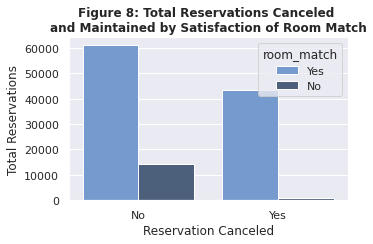

In [ ]:
# Determine which Rooms Match
room_match_df = original_d[["is_canceled", "reserved_room_type", "assigned_room_type"]]
room_match_df["res_assign"] = (
    room_match_df["reserved_room_type"] + "-" + room_match_df["reserved_room_type"])
room_match_df["room_match"] = np.where(
    (room_match_df["reserved_room_type"] == room_match_df["assigned_room_type"]), "Yes", "No")
room_match_df = room_match_df.drop(columns=["reserved_room_type", "assigned_room_type"])

#Plot
fig = plt.figure(figsize=(5, 3))
sns.barplot(x="is_canceled", y=0, hue="room_match", 
            data=room_match_df[["is_canceled", "room_match"]].value_counts().reset_index())
plt.xticks([0, 1], ["No", "Yes"])
plt.ylabel("Total Reservations")
plt.xlabel("Reservation Canceled")
plt.title("Figure 8: Total Reservations Canceled \nand Maintained by Satisfaction of Room Match",
          fontweight="bold")

It would be easy to hypothesise that if a guest was assigned to the type of room that they requested, then they would be less likely to cancel their booking. However, from Figure 8 above, we notice that there are still a high number of bookings that are canceled even when the guests are assigned to the type of room that they requested. This is somewhat logical as guests are often not informed of what roomed they are assigned to until they are at the hotel, and because bookings are usually canceled before guests arrive, it would not be unreasonable to assume that guests do not take this factor into account when making a decision on whether to cancel their booking or not. Despite this, as we are unaware of the hotel operator's specific polociy when it comes to informing guests of their room allocations, we shall assume that guests are informed of this allocation when their booking is confirmed and are able to use this to determine if they will cancel their booking or not. For this reason we chose to retain features regarding room allocations within our dataset.

There are a number of other features within the dataset that we performed one-hot encoding on. However, as these do not seem to be highly correlated with the feature ```is_canceled``` we decide not to explore these further here, and shall instead allow the model to determine if these features are important when predicting whether a reservation will be canceled or not. 

<br>

---
Returning to Table 8, we observe that `lead_time` is another feature that is positively correlated to `is_canceled`. 

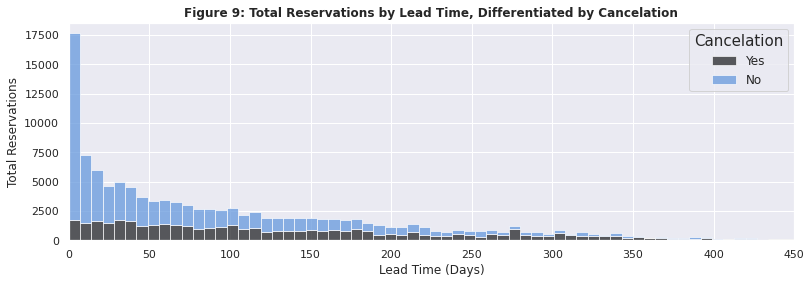

In [ ]:
fig = plt.figure(figsize=(13, 4))
sns.histplot(data=d[["is_canceled", "lead_time"]], x="lead_time", hue="is_canceled", binwidth=7, 
             multiple="stack", palette=sns.dark_palette("#69d", reverse=True, n_colors=2))
plt.ylabel("Total Reservations")
plt.xlabel("Lead Time (Days)")
plt.xlim(0, 450)
plt.title("Figure 9: Total Reservations by Lead Time, Differentiated by Cancelation",
          fontweight="bold")
plt.legend(["Yes", "No"], loc="upper right", title="Cancelation", fontsize=12, title_fontsize=15)

*Note: Figure excludes the extreme lead times (>450) as the trend line remains the same with the zoomed in view.*

Figure 9 above depicts that as the lead time of the booking decreases, the chance of a booking being canceled also decreases. This is a logical relationship (as the closer a booking is made to the date of arrival, the more certain the guests will be of their plans for the arrival date) and confirms the positive correlation between these two features that we observe above in Table 8.

Now that we have analysed and pre-processed our data, we begin fitting and tuning our model.

<br> 

---

## 3. Model Fitting and Tuning

As stated previosuly, in order to generate a profit while satisifying customer needs, it is vital that the hotel operator is able to predict which customers will cancel their bookings. Models that have a feature of interest in a binary format will have four potential outcomes: true positive, true negative, false positive, and false negative. As stated in section one, a *true positive* for this situation is when the model correctly predicts a cancelation and a *true negative* is when it properly predicts no cancelation. A *false positive* is when the model predicts a cancelation but no cancelation occurs. Finally, a *false negative* is when the model predicts no cancelation but a cancelation occurs. With this in mind, a specific point of concern for us as we modelled was ensuring that our model had high recall (low false positive and false negative rates).  

If the hotel was to expect a booking to be canceled when in fact it was not, the guest's room may not be ready on their arrival or even be available, which would have a negative effect on the hotel's reputation. Conversely, if the model predicted that a customer would not cancel their booking, when they infact did, the hotel would lose out on potential profits as a room would be empty. Moreover, we assume that the model we are creating is to be used on an ongoing basis by the hotel operator as a decision-making tool and must avoid overfitting as a result. Finally, as our cleaned dataset has high dimensionality, we emphasized dimensionality reduction in our model selection, to ensure our model would not be too computational expensive to implement. 

In addition to these asects related to cancelations, we are aware that the hotel operator is interested in a “White-Box” (i.e. easily explainable) model that is capable of accurately predicting when a booking would be canceled while also providing the hotel operator with specific insights into which aspects (features) are most likely to affect cancelations. We thus utilize supervised learning to create a classification model that is able to predict hotel cancelations with a high degree of accuracy while avoiding overfitting and limiting dimensionality. 

Before settling on a random forest classifier, we considered performing a principal component analysis (PCA). However, we realized that much of the clarity behind which features actually contribute to the predictive model would be removed. As this would hinder our ability to provide useful feedback to the hotel operator, we discarded this model. 

Next, we considered performing a LASSO logistic regression due to the algorithm’s use of shrinkage to reduce dimensionality and create a simple, sparse model based upon only key features. Unfortunately, although the model was highly accurate, it had poor overall recall (< 60%). As we believe this is an important aspect, we chose not to further pursue LASSO logistic regression. 

We opted for a random forest classifier as this “tree-based method" provides specific insight into which features have high predictive power based upon its node's gini index or entropy. As such, we are easily able to determine which features are of critical importance in predicting booking cancelations. In addition to this, we can easily limit overfitting by limiting the max tree depth to ensure that the model will continue to perform well on any future data from the hotel operator. Furthermore, random forest classifiers lend themselves well to being easily visualized, allowing for ease of understanding by individuals with little knowledge of machine learning. 

<br>

---
We begin by splitting the data into testing and training data. When doing so, we stratify the data to ensure that similar proportions of canceled bookings are in both the test set and training set. We also selected a random value of 23 to be our random state to allow for repeatable results. 

In [ ]:
# Dropping our outcome of interest from the dataframe.
X = d.drop(["is_canceled"], axis=1)
# Storing this outcome of interest.
y = d["is_canceled"]

# Splitting the data into testing and training sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=23)

Due to the large amount of binary features created by one-hot encoding within our dataset, when implementing the random forest classifier algorithm, we use min-max normalization to scale the features. This is to ensure that features are given equal importance by the model. Additionally, for reproducability, we select a random value of 42 for the random state.

We then implement a grid search cross-validation algorithm that alters the maximum depth of the random forest classifier tree between 15, 20, and 25 while also altering the criterion metric(the measure of split quality) of between “gini” (for the Gini impurity) and “entropy” (for information gain). The grid search helps us tune the model given our specified parameters and enables us to return a more prefered model.  

In [ ]:
# Create the model pipeline
estimators = [("forest", RandomForestClassifier(random_state=42))]
rd_clf = Pipeline(estimators)

# Determine the parameters for the grid search
parameters = {"forest__max_depth": [15, 20, 25], "forest__criterion": ["entropy", "gini"]}

# Create the fold mechanism and build the grid search
skf = StratifiedKFold(n_splits=5)
opt_rd_clf = GridSearchCV(rd_clf, parameters, cv=skf)
opt_rd_clf.fit(X_train, y_train)

# Predict the testing values
y_pred_rd_clf = opt_rd_clf.predict(X_test)

# Generate the performance metrics
acc_rd_clf = accuracy_score(y_test, y_pred_rd_clf)
conf = confusion_matrix(y_test, y_pred_rd_clf)
clf_report = classification_report(y_test, y_pred_rd_clf)
cv_result_df = pd.DataFrame(opt_rd_clf.cv_results_)
cv_result_df.params = [
    f"{x['forest__criterion']}, Max Depth: {x['forest__max_depth']}"
    for x in cv_result_df.params.values]

#Print the Performance Measures.
print("\n"f"Accuracy Score of Random Forest is: {acc_rd_clf}")
print(f"Confusion Matrix: \n{conf}")
print(f"Classification Report: \n{clf_report}\n")

# Print the cross validation results.
print("\033[1m" + "Table 9: Cross Validation Results" + "\033[0m")
cv_result_df.loc[:, "params":"rank_test_score"].sort_values(by=["rank_test_score"])\
[["params","split0_test_score", "split4_test_score", "mean_test_score", "std_test_score", "rank_test_score"]]


Accuracy Score of Random Forest is: 0.8608495359392995
Confusion Matrix: 
[[17374  1119]
 [ 2989  8040]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     18493
           1       0.88      0.73      0.80     11029

    accuracy                           0.86     29522
   macro avg       0.87      0.83      0.85     29522
weighted avg       0.86      0.86      0.86     29522


Table 9: Cross Validation Results


,params,split0_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,"gini, Max Depth: 25",0.851078,0.856546,0.855633,0.003077,1
2,"entropy, Max Depth: 25",0.849780,0.855078,0.854346,0.003191,2
4,"gini, Max Depth: 20",0.838602,0.843222,0.844015,0.003343,3
1,"entropy, Max Depth: 20",0.839505,0.840908,0.843281,0.003298,4
3,"gini, Max Depth: 15",0.820989,0.823689,0.825655,0.003422,5
0,"entropy, Max Depth: 15",0.819634,0.822955,0.824222,0.002891,6


From Table 9 above, which despicts the results of our grid search cross-validation algorithm, it is clear to see what our optimal parameters for the model are. Using these, we then observe that in our tuned random forest classifier, we obtain relatively high model accuracy, precision, and (most importantly) recall values, indicating that the random forest classifer is an appropriate model choice in this instance. Both the precision scores for canceled (1) and not cancaled (0) are greater than 85%, showing a high model accuracy. Moreover, the recall score for no cancelation is extremely high with a value of 94%. Although the recall score for canceled is smaller than the rest, it is still relatively high with a value of 73%. Hence, we believe that this is a good model that can provide reliable feedback as to which reservations may be canceled. We shall continue discussions about the consequences of our model's accuracy in Section 4. 

<br>

---

As this is a large hotel operator, we understand that there may be times when the company creates sweeping changes regardless of hotel types. For this reason, we believe that an all-encompassing model is extremely important to create, as we have done so above. However, we also appreciate that the company or even an individual hotel manager may want to specify changes for a particular hotel or group of hotels. For this reason, we believe it is also important to implement the Random Forest Classifier model for both the resort hotels and city hotels individually. This will allow us to better understand if there are any features that are better at predicting cancelations given a specific hotel type, especially as we know that guests may book to stay at one of the two hotels for very different reasons. 

Therefore, below, we utilise our model tuned model (with optimal parameters) to analyse how well it performs on data from the two hotels individually. 

In [ ]:
# ============City Dataset and Model=================
city_d = d[d["is_resort"] == 0]
city_d = city_d.drop(["is_resort"], axis=1)

# City Data
X_city = city_d.drop(["is_canceled"], axis=1)
y_city = city_d["is_canceled"]
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_city, y_city, test_size=0.25, random_state=23, stratify=y_city)

# Set rd_clf previous gridsearch parameters.
rd_clf.set_params(**opt_rd_clf.best_params_)

# Run the model
rd_clf_c = clone(rd_clf)
rd_clf_c.fit(X_train_c, y_train_c)

y_pred_rd_clf_c = rd_clf_c.predict(X_test_c)
acc_rd_clf_c = accuracy_score(y_test_c, y_pred_rd_clf_c)
conf_c = confusion_matrix(y_test_c, y_pred_rd_clf_c)
clf_report_c = classification_report(y_test_c, y_pred_rd_clf_c)

# ============Resort Dataset and Model=================
resort_d = d[d["is_resort"] == 1]
resort_d = resort_d.drop(["is_resort"], axis=1)

# City Data
X_resort = resort_d.drop(["is_canceled"], axis=1)
y_resort = resort_d["is_canceled"]
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_resort, y_resort, test_size=0.25, random_state=23, stratify=y_resort)

# Run the model
rd_clf_r = clone(rd_clf)
rd_clf_r.fit(X_train_r, y_train_r)

y_pred_rd_clf_r = rd_clf_r.predict(X_test_r)
acc_rd_clf_r = accuracy_score(y_test_r, y_pred_rd_clf_r)
conf_r = confusion_matrix(y_test_r, y_pred_rd_clf_r)
clf_report_r = classification_report(y_test_r, y_pred_rd_clf_r)

# Printing Results of for City and Resort Hotels
print(f"Accuracy Score of City Hotel Random Forest is: {acc_rd_clf_c}")
print(f"Classification Report for City Hotel: \n{clf_report_c}")
print("\n")
print(f"Accuracy Score of Resort Hotel Random Forest is: {acc_rd_clf_r}")
print(f"Classification Report for Resort Hotel: \n{clf_report_r}")

Accuracy Score of City Hotel Random Forest is: 0.8622718052738336
Classification Report for City Hotel: 
              precision    recall  f1-score   support

           0       0.85      0.93      0.89     11458
           1       0.89      0.77      0.82      8262

    accuracy                           0.86     19720
   macro avg       0.87      0.85      0.86     19720
weighted avg       0.86      0.86      0.86     19720



Accuracy Score of Resort Hotel Random Forest is: 0.8668774864837294
Classification Report for Resort Hotel: 
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      7036
           1       0.82      0.68      0.74      2767

    accuracy                           0.87      9803
   macro avg       0.85      0.81      0.83      9803
weighted avg       0.86      0.87      0.86      9803



Here, we see that the overall performance of our model has remained relatively high when we utilize the model for data from each of the hotels separately. Although there is a slight decrease in recall for reservation cancelations at Resort Hotels, we surmise that this decrease could be related to a slight difference in which features affect resort cancelations. That said, the score is still relatively high, and so we conclude that the hotel operators could confidently use this model on data from different subsets of their hotels. 

Text(0.5, 1.0, 'Figure 10: ROC curve')

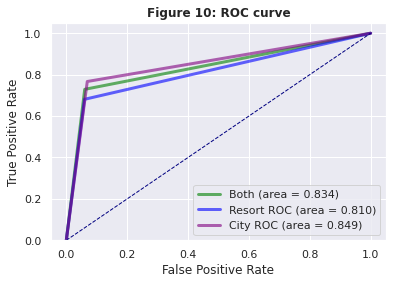

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_rd_clf, pos_label=1)
fpr_r, tpr_r, thresholds_r = metrics.roc_curve(y_test_r, y_pred_rd_clf_r, pos_label=1)
fpr_c, tpr_c, thresholds_c = metrics.roc_curve(y_test_c, y_pred_rd_clf_c, pos_label=1)

#plot roc curves
fig = plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, lw=3, alpha=0.6, color="green",
         label="Both (area = %0.3f)" % (roc_auc_score(y_test, y_pred_rd_clf)))

plt.plot(fpr_r, tpr_r, lw=3, alpha=0.6, color="blue",
         label="Resort ROC (area = %0.3f)" % (roc_auc_score(y_test_r, y_pred_rd_clf_r)),)

plt.plot(fpr_c, tpr_c, lw=3, alpha=0.6, color="purple",
         label="City ROC (area = %0.3f)" % (roc_auc_score(y_test_c, y_pred_rd_clf_c)))

# Formating the Plot
plt.xlim([-0.05, 1.05])
plt.ylim([0.0, 1.05])
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title("Figure 10: ROC curve", fontweight="bold")

We are looking for our model to have a a high true positive rate and low false positive rate, so in a perfect scenario the ROC curve for such a model would be flushed to the top left hand corner. From Figure 10 we see that even when applied to all of the datasets, our model performs relatively well with low false positive rates and high true positive rates. 

Due to these strong performance measures, we feel confident that the model is capable of providing useful and reliable information to the hotel operator regarding canceled bookings. 

<br>

---

## 4. Discussion & Conclusions

###Model Performance and Reliability:

					Figure 10: Confusion Matricies


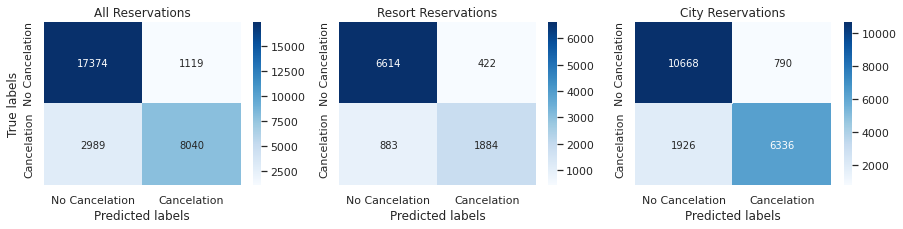

In [ ]:
# Generate the heatmaps for the confusion matrix
fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.heatmap(conf, annot=True, fmt="g", cmap="Blues", ax=ax[0],
            xticklabels=["No Cancelation", "Cancelation"],
            yticklabels=["No Cancelation", "Cancelation"])
ax[0].set_title("All Reservations")
ax[0].set_xlabel("Predicted labels")
ax[0].set_ylabel("True labels")

sns.heatmap(conf_r, annot=True, fmt="g", cmap="Blues", ax=ax[1],
            xticklabels=["No Cancelation", "Cancelation"],
            yticklabels=["No Cancelation", "Cancelation"])
ax[1].set_title("Resort Reservations")
ax[1].set_xlabel("Predicted labels")

sns.heatmap(conf_c, annot=True, fmt="g", cmap="Blues", ax=ax[2], 
            xticklabels=["No Cancelation", "Cancelation"],
            yticklabels=["No Cancelation", "Cancelation"])
ax[2].set_title("City Reservations")
ax[2].set_xlabel("Predicted labels")

print("\t\t\t\t\t\033[1mFigure 10: Confusion Matricies\033[0m")

For context, the confusion matrix displays the true negative (top left), false positive (top right), false negative (bottom left), and true positive (bottom right) values of a given model. Each of these terms are defined at the beginning of Section 3. 
 
Correctly predicting when an individual/group will cancel their reservation is extremely important for a hotel as they must ensure that they prepare and have the correct number of rooms available each night. Failing to do so could negatively affect their reputation and profit margins, as we have previously discussed within this report. 
 
<br>
 
*Model Predicts a Cancelation*
 
Given reservations for both of the hotels, the model predicts that 31% of reservations will be canceled. Of these predicted cancelations, nearly 88% are correctly predicted by the model (and so are true positives). As the model often correctly predicts cancelations, the hotel company can be confident in the model’s prediction and react accordingly. By this, we mean that if the model suggests that a booking will be canceled, it is highly likely that the guests will not show up. Hence, their room can be reassigned to new guests and the hotel will not miss out on potential income.
 
We appreciate that while we have minimized our false positive rate as much as possible, there is still the possibility that the guest will show up even if the model suggests that their booking will be canceled. If no rooms are reserved for these individuals, then when they show up the room might not yet be ready or their room could have been double booked (if it had been reassigned to another customer). To account for this, and to help protect the hotel’s image as much as possible, we suggest that the managers reserve a small proportion of rooms each night for the scenario of an unexpected guest arriving. Alternatively, the hotel operator could ask guests to confirm their booking shortly before arrival, to allow them to overwrite the model’s prediction if it is incorrect, to ensure the correct number of rooms are available each night. These are both simple solutions to implement which is why we feel the model performs appropriately when it predicts a cancelation.

*Model Does Not Predict a Cancelation*
 
Alternatively, the model predicts that 69% of reservations from both of the hotels will not be canceled. Of these, 85% are correctly predicted (true negatives). In this case, we would expect the hotel to assume that these customers will maintain their reservations. This means that they should mark these customers' rooms as unavailable and ensure that the room is ready for them upon arrival. 
 
We recognize that, although the model has a relatively strong predictive power, there are cases when the model incorrectly predicts that an individual/group will not cancel (false negative). This means that the hotel will likely lose out on potential profits as a room would be empty. Even though this is not the best situation, it is not detrimental to their reputation. Additionally, due to the low proportion of false negatives, there will be very few instances of empty rooms, meaning that the hotel operators will not lose a significant amount of money. 

This explains why overall we deem our model to be appropriate for implementation by the hotel operators; no matter which dataset we run the model for, the hotel is set to lose very little (if any) money for unused rooms, nor should their public image be negatively affected as a result of double booked rooms. 

<br>

### Results and Feature Importance

Now that we have verified that the model we built has high accuracy, precision, and recall, we can now extract feature importance for each of the three datasets. By determining feature importance, we will be able to better understand which features are the biggest indicators of future booking cancelations and thus be able to accurately consult the hotel operator on which booking features it should pay specific attention to.

<br>

**Feature Importance**

In [ ]:
# create feature importance dataframes
all_feats = pd.DataFrame(zip(X.columns, opt_rd_clf.best_estimator_.steps[1][1].feature_importances_),
                         columns=["feature", "importance"])
resort_feats = pd.DataFrame(zip(X_resort.columns, rd_clf_r.steps[1][1].feature_importances_),
                            columns=["feature", "importance"])
city_feats = pd.DataFrame(zip(X_city.columns, rd_clf_c.steps[1][1].feature_importances_),
                          columns=["feature", "importance"])

# sort by importance
all_feats = all_feats.sort_values(by="importance", ascending=False)
resort_feats = resort_feats.sort_values(by="importance", ascending=False)
city_feats = city_feats.sort_values(by="importance", ascending=False)

# Compare feature importances
print("\033[1mTable 11: Feature Importance given different Datasets\033[0m")
pd.concat([all_feats[:7], resort_feats[:7], city_feats[:7]], keys=["Both", "Resort", "City"], axis=0).\
style.bar(subset=["importance"], color=["#649FEB"], vmin=0, vmax=1, axis=0, align="zero")

Table 11: Feature Importance given different Datasets


Feature importance is a value between 0 and 1, with 1 being very important in determining if a booking is canceled or not and 0 being insignificant in comparison. We observe that no feature in isolation has significant importance; however, we can see that some features are more important than others. This provides an indication of what areas the hotel operator should focus on when preventing cancelations.

From the above, we observe that "Both" and "City" have very similar feature importance with each of their top three features being `deposit_type_Non Refund`, `lead_time` and `deposit_type_No Deposit`. Resort differs slightly in that its top two most important features are `lead_time` and `adr`. This indicates that, when analyzed in isolation, "City" and "Resort" hotels have different drivers behind booking cancelations, whereas, when analyzed in conjunction, the driver behind each hotel type's booking cancelations converge. This result is particularily interesting as "Resort" has a higher number of observations than "City" (40,060 and 29,096, respectively). We can thus conclude that most important features of "City" have more predictive power than the most important features of "Resort".

It is important to note that, despite feature importance enabling us to determine which features are most indicative of a booking being canceled or not, we unfortuntately do not known if these features indicate that a booking is more likely to be canceled (i.e. `is_canceled` = 1) or is less likely to be canceled (i.e. `is_canceled` = 0). To determine this, as well as to enhance our understanding of the relationships between features cancelations, we will now visualize a decision tree.

<br>

--- 

**Please note:** *A random forest classifier builds many random decision trees and then determines feature importance by returning the features with the largest average criterion size across all trees, regardless of its depth within the tree. As such, the below visualization will likely not display the features indicated to be important in the above high within the tree. When analyzing the below trees, what should be noted is the marginal gini coefficient present in the nodes of features deemed to be 'highly imporant'*

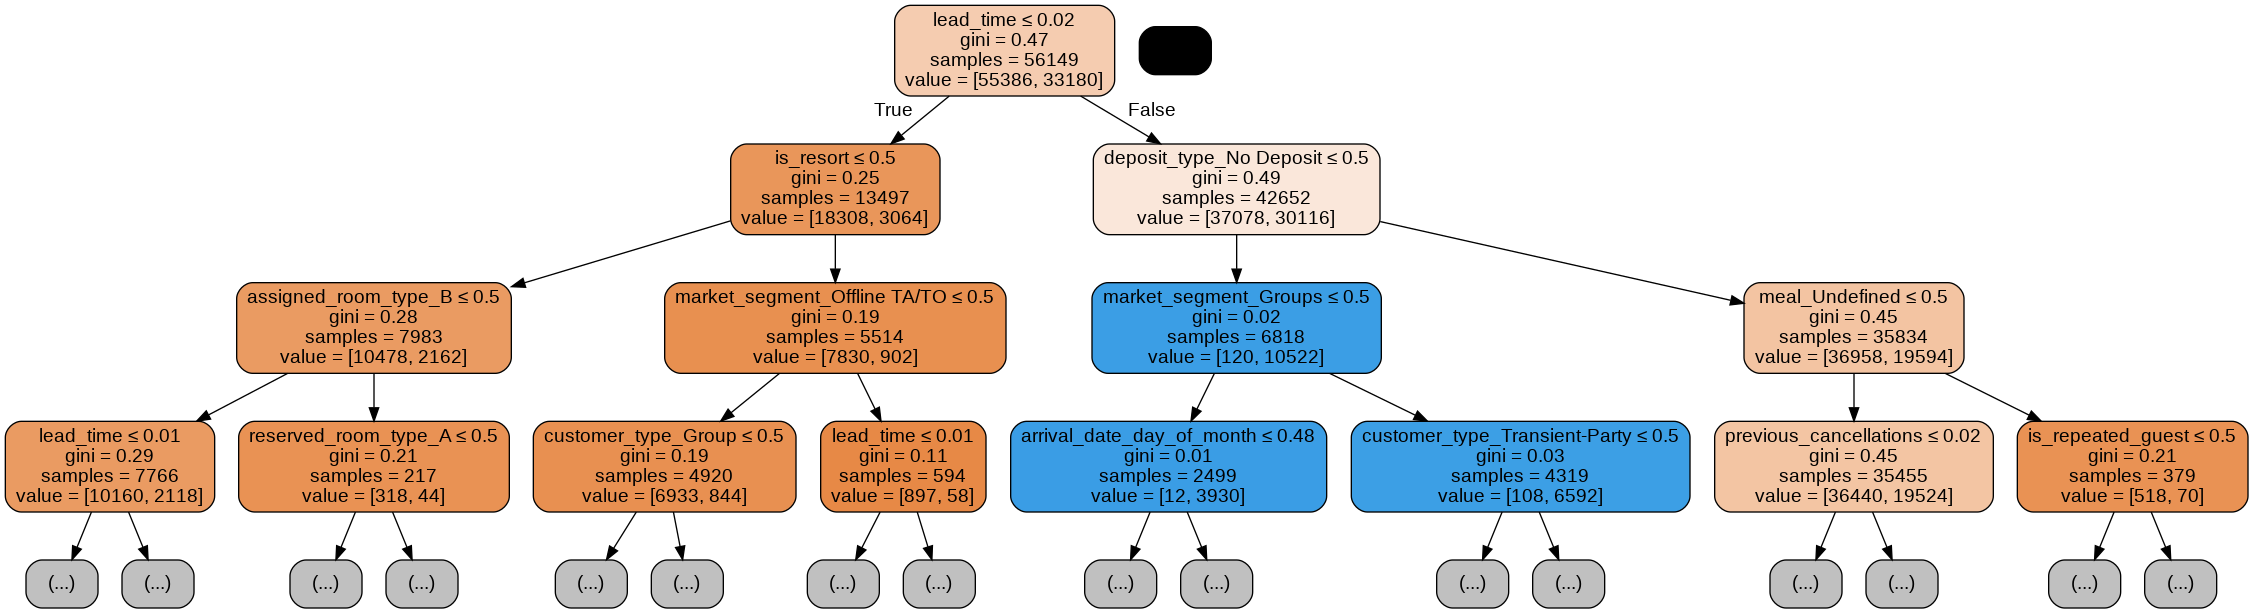

In [ ]:
# Visualize the random forest to better understading of the biggest drivers
best_pipeline = opt_rd_clf.best_estimator_

dot_data = StringIO()

cols = d.drop(["is_canceled"], axis=1).columns

export_graphviz(best_pipeline["forest"].estimators_[27], max_depth=3, out_file=dot_data,
                rounded=True, proportion=False, precision=2, filled=True, special_characters=True, 
                feature_names=cols)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

**Decision Tree Visualization Explaination**

The above tree displays how cancelaion predictions shift based on feature presence and relationships. Arrows pointing to the left mean that the first statement in a node is true while arrows pointing to the right indicate the statement is false. The final line in each node "value", states the marginal number of bookings reclassed from canceled to not canceled and vice versa from the combination of features. This line should be read as follows: ***value*** = [*bookings labeled 'canceled' reclassed to 'not canceled' after previous split, bookings labeled 'not canceled' reclassed to 'canceled' after previous split*\]. Finally, the line "gini" is indicative of the probability that feature is classified incorrectly (Tyagi, 2020). As such, a gini close to 0 indicates that the features are very likely to be classed correctly while a gini close to 1 indicates that features are likely to be classed incorrectly. 

**Please note:** A leaf having a deeper orange colour is indicative that the split is a good indicator of a booking *not being* canceled when it occurs in conjunction with the features from the previous leaves higher in the tree. A leaf being blue indicates that the split is a good indicator of a booking *being* canceled when it occurs in conjunction with the features from previous. Furthermore, all non-binary features were min-max scaled, as such its value can per interpreted as a percentile. Ex: within the first node we observe "```lead_time``` <= 0.03". This is indicative that a decision tree split occurs when the feature ```lead_time``` is at or below its 3rd percentile.

<br>

**Analysis**

We observe from the above decision tree several important characteristics of highly important features. We first note that when a booking has a relatively low lead time of less than 14 days, (as indicated by `lead_time` <= 2nd percentile), the model is highly certain that the booking will not be canceled – as displayed by all proceeding leaf nodes being darker orange and maintaining low gini indexes. This agrees with the trend observed in Figure 9, and supports the idea that the closer to the arrival date a customer books, the less likely they are to cancel as they are more likely to know what their plans are.
 
We appreciate that how far in advance a customer decides to make a booking is not entirely controllable by the hotel operator; however, there are a few measures that they can take to prevent cancelations here. For example, the hotel could prevent bookings being made more than a certain number of days in advance of an arrival date. Conversely, they could create deals or promotions to incentivise customers to book closer to their arrival date. Please note here, we are only making suggestions based on the hotel operator preventing cancelations and we appreciate that before implementing these changes, managers must consider the implications that these may have on other areas of their business. 
 
We further note that if a booking has either a refundable or a non-refundable deposit (as indicated by `deposit_type_No Deposit` being <= 0.5), then that booking will likely be canceled as noted by low gini index of 0.02. Furthermore, if the `lead_time` is greater than 14 days, the tree suggests that making these customers put down a deposit will increase the likelihood of cancelations. Therefore the hotel might want to consider excluding a deposit as an option for individuals booking more than 14 days out. Although, as mentioned in section 2, this result appears to be counterintuitive, and so the hotel may want to investigate this further with a more comprehensive dataset before implementing such a policy. 
 
Finally, we notice the other major node, `is_resort` high in the tree. This further supports some of our feature analysis that illustrates varying feature importance between the city and resort datasets. As City Hotels and “All” hotels have relatively similar feature importances, we shall now more closely examine how feature importance might shift for Resort Hotels.


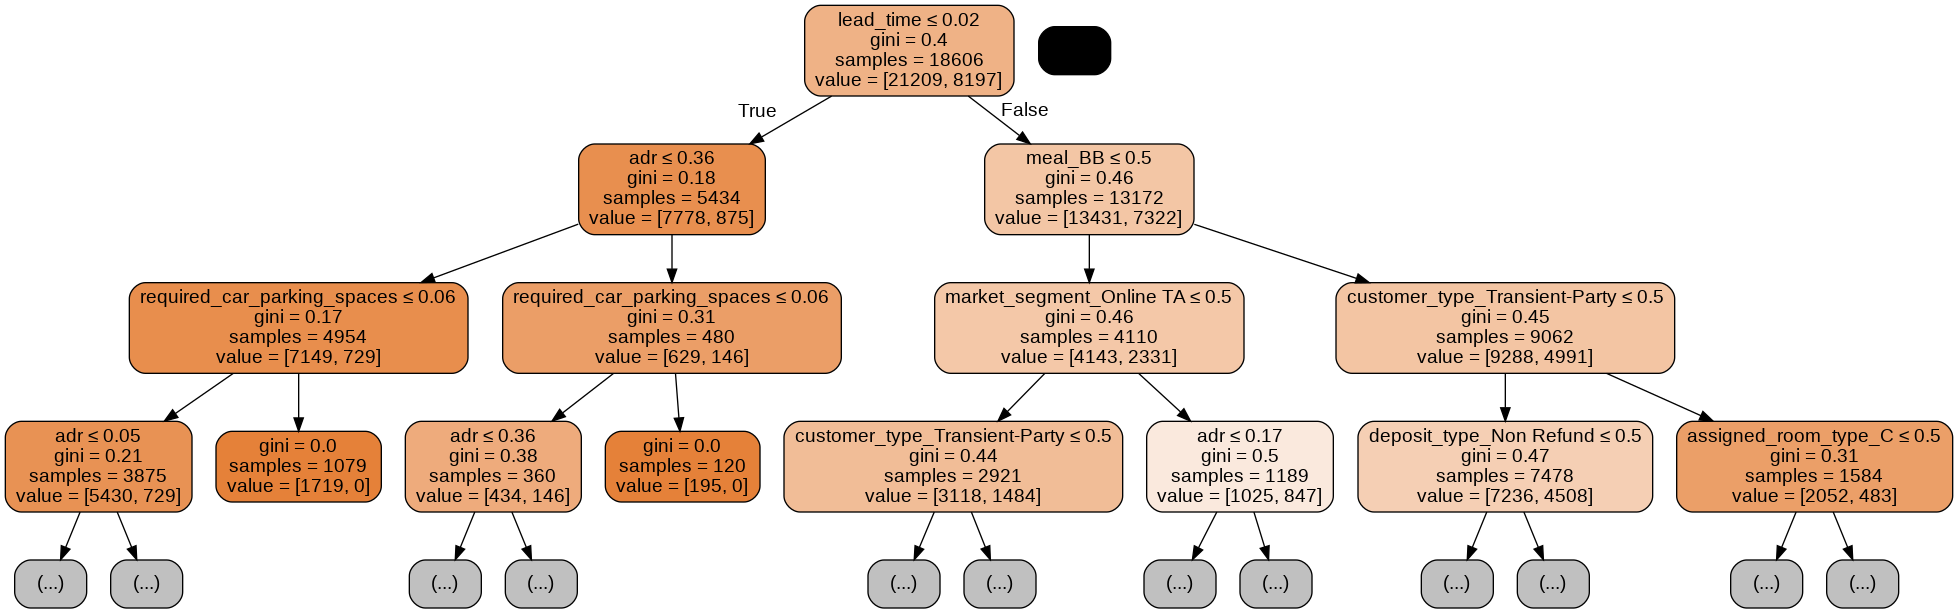

In [ ]:
# Visualize the random forest to better understading of the biggest drivers
dot_data = StringIO()

cols = resort_d.drop(["is_canceled"], axis=1).columns

export_graphviz(rd_clf_r["forest"].estimators_[45], max_depth=3, out_file=dot_data, rounded=True,
                proportion=False, precision=2, filled=True, special_characters=True, feature_names=cols)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

**Analysis**

Based on the orange coloration of the nodes, we clearly see that the features deemed to be "important" for Resort hotels are highly predictive of bookings not being canceled. Looking specifically at the features `lead_time`, `adr`, and `required_car_parking_spaces`, we see that their presence, or absence, within a booking alone maintain high degrees of predictive power, as is confirmed by the feature importances above. 
 
Again, we see that if `lead_time` is 14 days or less (i.e. is <= its 2nd percentile) the hotel operator can be certain (i.e. gini = 0.18) that a booking will not be canceled. Further, if this occurs in conjunction with an average daily rate (`adr`) of 1940 or less (i.e <= 36th percentile) then the hotel operator has even more certainty that a booking will not be canceled. 
 
Finally we see that if a customer requests a car parking space, it is more likely that they will not cancel their booking. This is logical because the more thought and consideration a guest puts into their stay, the more likely they are to arrive at their hotel and not cancel their booking. As a result we could suggest to the hotel operators to ensure that there is sufficient parking available, especially at their Resort Hotels. Similarly, this could indicate to the hotel operators that in order to prevent people from canceling their bookings, they need to offer more small incentives to make people’s journey to and from the hotel easier. 

<br>

---

###Final Conclusions

We have developed a model that performs exceedingly well as it runs with a high accuracy score and high recall. As a result, the hotel operator can implement the model knowing that it will have a better understanding of why some customers cancel their booking, without introducing any further negative implications on their business. 
 
 
While we have analysed features for each of the Resort and City hotels individually, we shall focus our recommendations on suggestions to the hotel operators on what we expect to have the greatest impact across all of the operator's hotels. Accordingly, we conclude that the hotel operator should:
 
1. Encourage individuals to book closer to the arrival date. 
2. Explore excluding a deposit as an option when lead time exceeds 14 days. 
 
One aspect to consider in increasing customers' willingness to book closer to their arrival datec, is to make more appealing deals available to such customers. This is a key balance that the hotel will have to determine as some individuals, who have no choice, will pay a larger hotel fee while others are more likely to “shop around” for a decent hotel price. One way the hotel operators could try to balance this payoff is through the average daily rate `adr`. As we noticed with resort hotels, there may be some factors that could incentivise individuals to book closer to an arrival date without the hotel losing out on profit (as those individuals are almost certain to keep their reservation). This aspect will need greater investigation as to what this price is and how it might shift throughout the year. For example, customers typically expect to pay more around the holidays and when major sporting competitions occur in different areas. These aspects could all help determine the optimal price to set closer to their reservation date. 
 
Although the hotel might lose £10 on a hotel reservation that was originally £150 given a recommended price from `adr` analysis, the hotel does gain a greater confidence that the individual will maintain their reservation. Therefore, the hotel will make money (so long as they maintain hotel room pricing equal to profit of greater than 0). Again, `adr` is just one way our team surmises that the hotel could incentivize customers to book in closer to their stay.  
 
Finally, the hotel operator should reevaluate some of their policies related to deposit type. We noticed that `lead_time` in conjunction with deposit type has a large effect on cancelation predictions. As a company immediately knows when an individual or group wants to schedule their hotel stay, the company could institute a policy that automatically adjusts acceptable forms of deposits. Although there would need to be further investigation on what deposits to exclude given varying parameters, we do know that, in relation to `lead_time`, only Refundable and Non Refundable deposit types should be options when the `lead_time` is two weeks or less. 



<br>

## References 
> Stack Overflow. (n.d.). python - Reshaping a pandas correlation matrix. [online] Available at: https://stackoverflow.com/questions/38057416/reshaping-a-pandas-correlation-matrix [Accessed 13 Apr. 2022].

> Tyagi, N. (2020). Understanding the Gini Index and Information Gain in Decision Trees. [online] Medium. Available at: https://medium.com/analytics-steps/understanding-the-gini-index-and-information-gain-in-decision-trees-ab4720518ba8.

‌
